In [2]:
import rioxarray as rxr
import os
from rasterio.plot import show
from PIL import Image
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape
import pandas as pd

In [3]:
def load_data_from_file(contained_file):
    # load the data
    with open(contained_file) as f:
        lines = f.readlines()
        # reteive line infos
        segment_id = []
        polygon_id = []
        class_id = []
        pixels = []
        for line in lines:
            # retrieve segment id
            segment_id.append(line.split(',')[0].split(':')[1].strip())
            # retrieve polygon id
            polygon_id.append(line.split(',')[1].split(':')[1].strip())
            # retrieve class id
            class_id.append(line.split(',')[2].split(':')[1].strip())
            # retrieve pixels
            pixel_list_str = line.split(':')[4]
            pixel_list_str = pixel_list_str[3:-3]
            pixel_list = list(pixel_list_str.split('], ['))
            pixel_list = [pixel.split(', ') for pixel in pixel_list]
            pixel_list = [[int(pixel[0]), int(pixel[1])] for pixel in pixel_list]
            pixels.append(pixel_list)
        
        # create a dataframe
        df = pd.DataFrame()
        df['segment_id'] = segment_id
        df['polygon_id'] = polygon_id
        df['class_id'] = class_id
        df['pixels'] = pixels
        
        return df

In [4]:
# retreive some infos on fully contained segments
contained_file_50 = 'data/contained_segments_50.txt'
contained_file_0001 = 'data/contained_segments_0001.txt'
contained_file_100 = 'data/contained_segments_100.txt'

In [5]:
dataframe = load_data_from_file(contained_file_50)

In [6]:
print('Number of segments: ', len(dataframe))
# print the total number of pixels
total_pixels = 0
for pixels in dataframe['pixels']:
    total_pixels += len(pixels)
print('Total number of pixels: ', total_pixels)

Number of segments:  4795
Total number of pixels:  77577


In [7]:
# show mean number of segment per polygon
print('Mean number of segment per polygon: ', len(dataframe)/len(dataframe['polygon_id'].unique()))

Mean number of segment per polygon:  6.384820239680426


In [8]:
folder = "D:/General/ExaplAInability_Data/transfer_6060512_files_e989f8bb"

list_bands = ['02', '03', '04', '05', '06', '07', '08', '8A', '11', '12']

In [11]:
def clip_all_acquisition(band, output_folder):

    with rasterio.open(band) as src:
        for acquisition in range(1, src.count + 1):
            print(f"Acquisition {acquisition}/{src.count}")
            data_array = src.read(acquisition)
            min_val = (np.percentile(data_array, 2))
            max_val = (np.percentile(data_array, 98))
            norm_band = np.clip( (data_array - min_val) / (max_val - min_val), 0, 1).astype('float32')
            print(f"Min: {min_val}, Max: {max_val}, Mean: {np.mean(norm_band)}")
            
            # Define the output file path for the normalized band
            output_path = os.path.join(output_folder, f'normalized_{os.path.basename(band)}_Acquisition_{acquisition}.tif')

            # Create a new GeoTIFF file with a custom profile and write the normalized data
            profile = src.profile.copy()
            profile.update(count=1, dtype='float32')  # Set the count to 1 for a single band
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(norm_band, 1)

In [9]:
for band in list_bands:
    print(f"Band {band}")
    band_file = os.path.join(folder, 's2_2020_B' + band + '.tif')
    output_folder = os.path.join(folder, 'normalized_gathered_output')  # Output folder for the normalized bands
    os.makedirs(output_folder, exist_ok=True)
    clip_all_acquisition(band_file, output_folder)

Band 02
Acquisition 1/73
Min: 551.0, Max: 1180.0, Mean: 0.422119140625
Acquisition 2/73
Min: 601.0, Max: 1206.0, Mean: 0.42724609375
Acquisition 3/73


KeyboardInterrupt: 

Testing the normalization

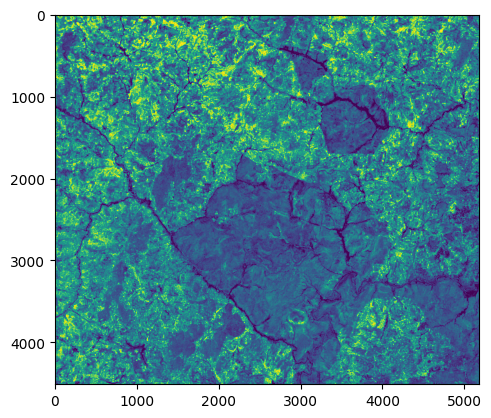

In [15]:
file = os.path.join(folder, 'normalized_gathered_output/normalized_s2_2020_B02.tif.tif')
# show infos on the tif file
with rasterio.open(file) as src:
    '''print(src.profile)
    print(src.bounds)
    print(src.crs)
    # show shape
    print("passe")
    print(len(src.read(1)))
    print(src.count)
    # lets see the min max mean values
    print(np.min(src.read(1)))
    print(np.max(src.read(1)))
    print(np.mean(src.read(1)))
    # lets show acquisition 10'''
    show(src.read(73))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 5183, 'height': 4513, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 402570.0,
       0.0, -10.0, 1257190.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
BoundingBox(left=402570.0, bottom=1212060.0, right=454400.0, top=1257190.0)
EPSG:32630
passe


4513
1
0.0
1.0
0.42213112


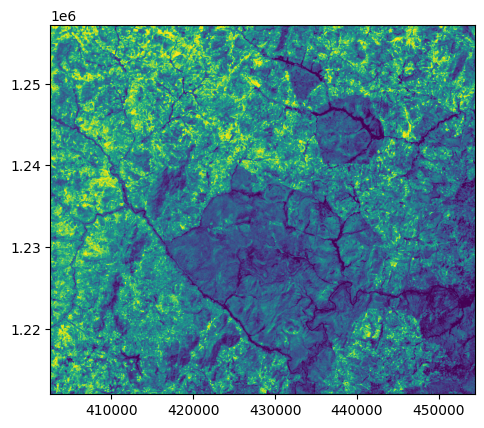

In [47]:
file = os.path.join(folder, 'normalized_output/normalized_s2_2020_B02.tif_Acquisition_1.tif')
# show infos on the tif file
with rasterio.open(file) as src:
    print(src.profile)
    print(src.bounds)
    print(src.crs)
    # show shape
    print("passe")
    print(len(src.read(1)))
    print(src.count)
    # lets see the min max mean values
    print(np.min(src.read(1)))
    print(np.max(src.read(1)))
    print(np.mean(src.read(1)))
    # lets show it as an image
    show(src)